In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt1
from matplotlib import pyplot as plt2
import uproot
import pandas as pd
from histbook import *
from vega import VegaLite as canvas                
import vega
from sklearn import datasets
from sklearn import linear_model
#import datacompy
import numpy.testing as npt
from matplotlib.colors import LogNorm
import h5py
from scipy.optimize import nnls
from scipy.optimize import lsq_linear

In [2]:
pwdir=os.getcwd()
print(pwdir)

/grid_mnt/vol__vol_U__u/llr/cms/ahuja/HGCAL/ClusterCalib/jupyter/rphiseedingstudies/v3140


In [3]:
def rmseff(x, c=0.68):
    """Compute half-width of the shortest interval containing a fraction 'c' of items in a 1D array."""
    x_sorted = np.sort(x, kind="mergesort") 
    m = int(c * len(x)) + 1
    return np.min(x_sorted[m:] - x_sorted[:-m]) / 2.0

In [4]:
def rms(x):
    x_sorted = np.sort(x, kind="mergesort") 
    x_m = np.mean(x)
    x_sqr = np.square(x - x_m)
    x_r = np.mean(x_sqr)
    return np.sqrt(x_r)

In [5]:
def sig(df):
    d = pd.DataFrame()
    sel0 = ((df.best_match==True) & (abs(df.genpart_eta) < maxeta))
    sel = (abs(df.genpart_eta) < maxeta)
    srr = (df[sel].cl3d_srrtot)
    d['srr'] = srr
    spp = pd.Series(df[sel].cl3d_spptot)
    d['spp'] = spp
    return d

In [6]:
def delta(df):
    d = pd.DataFrame()
    sel0 = (df.best_match==True)
    #print(df)
    r0 = np.tan(2*np.arctan(np.exp(-df[sel0].cl3d_eta)))
    r1 = np.tan(2*np.arctan(np.exp(-df.cl3d_eta)))
    tmpr = r1 - r0
    dr = tmpr
    tmpphi = df.cl3d_phi-df[sel0].cl3d_phi
    dphi = tmpphi
    mgeneta = pd.Series(df[sel0].genpart_eta)
    d['dr'] = dr
    d['dphi'] = dphi
    d['mgeneta'] = mgeneta
    #print(d)
    return d

In [7]:
algoTitle=['Phibin54','Phibin108','Phibin162','Phibin189','Phibindef','Phibin243','Phibin270','Phibin324']
algos=['F8TPhibin54','F8TPhibin108','F8TPhibin162','F8TPhibin189','F8TPhibindef','F8TPhibin243','F8TPhibin270','F8TPhibin324']
algoVar=['default','optimal']
binning_study = 'False' 
plotresolution = 'True'
maxeta = 3.0
algo={}

In [8]:
path_input='/data_CMS/cms/ahuja/HGCAL/ntuples/tpgV3140/outhdffiles/RelValV10/RelValDiG_Pt10To100_Eta1p6To2p9_thEWthrdrvariationsPU0NoSmoothing/'
os.chdir(path_input)
for i in range(len(algos)):
    algo[i]=pd.read_hdf(path_input+'/{}.hdf5'.format(algos[i]))

In [9]:
path_output=pwdir+'/binningsizestudy/'
os.chdir(path_output)
print(path_output)

/grid_mnt/vol__vol_U__u/llr/cms/ahuja/HGCAL/ClusterCalib/jupyter/rphiseedingstudies/v3140/binningsizestudy/


In [10]:
##weights from PU0       
coefflinblsqPU0 = np.array([[2.0, 2.0, 0.95062643, 1.0030682, 1.0327549, 1.1912421, 1.0260687, 1.0854282, 1.0544152, 0.87490886, 0.95562255, 1.2274776, 2.0, 2.0],
[2.0, 1.8448473, 0.85374415, 1.0400898, 1.0325083, 1.1799846, 1.239296, 1.2025611, 1.1393944, 0.80136836, 1.221621, 1.6375958, 2.0, 2.0],
[2.0, 1.8195915, 0.85492253, 0.98388064, 0.98896986, 1.1360534, 0.9624911, 1.0211294, 1.0269748, 0.75643367, 0.9188006, 1.2177008, 2.0, 2.0],
[2.0, 2.0, 1.0570714, 1.1550162, 1.1847976, 1.2261918, 1.128439, 1.2103412, 1.1432166, 0.8886641, 1.0990212, 1.4831506, 2.0, 2.0],
[2.0, 1.927051, 1.1045128, 1.1405212, 1.1927637, 1.1933043, 1.2041622, 1.4070597, 1.1655806, 0.82913625, 1.3119591, 1.621659, 2.0, 2.0],
[2.0, 1.9290781, 0.8920883, 1.0398002, 1.0523514, 1.209122, 1.0390534, 1.1881673, 0.9755615, 0.9599909, 0.8824892, 1.4459158, 2.0, 2.0]
                            ])                       

In [11]:
calibration = 'direct'
PUmethod = 'none' ## input with 'direct'
#PUmethod = 'etaCorr' ## input with 'direct'
##PUmethod = 'sub'  ## input with 'direct'
#calibration = 'corrPU0'
algoSel={}
for i in algo:
    print(i)
    print(algos[i]) 
    selInitial = ((np.abs(algo[i]['genpart_eta']) > 1.6) & (np.abs(algo[i]['genpart_eta']) < 2.9)
                  & (algo[i]['genpart_pt'] > 10.0) & (algo[i]['best_match']==True))  
    algoSel[i] = algo[i][selInitial]
    layerpt = algoSel[i]['layer']

    cllayerpt = [[0 for col in range(14)] for row in range(len(layerpt))] ##only em layers
    for l in range(len(layerpt)):
        for m in range((len(layerpt.iloc[l]))):
            if(m>0 and m<15):  
                cllayerpt[l][m-1]=layerpt.iloc[l][m] 

    ##uncorrected res
    resUn = (algoSel[i]['cl3d_pt'])/algoSel[i]['genpart_pt']
    meanUn = np.mean(resUn)
    effrmsUn = rmseff(resUn)
    ratioUn=effrmsUn/meanUn
    #Bounds = (algo[i]['genpart_pt'][sel])/(algo[i]['cl3d_pt'][sel])
    #meanBounds = np.mean(Bounds)
    meanBounds = 1/meanUn 
    
    ##coefficients
    if(calibration == 'direct'):
        if(PUmethod == 'none'):
            lsqbregr_mean=lsq_linear(list(cllayerpt), (algoSel[i]['genpart_pt']), bounds = ((meanBounds)/2.0,(meanBounds)*2), method='bvls', lsmr_tol='auto', verbose=1)
            lsqbregr_def=lsq_linear(list(cllayerpt), (algoSel[i]['genpart_pt']), bounds = (0.5,2.0), method='bvls', lsmr_tol='auto', verbose=1)
        if(PUmethod == 'sub'):
            algoSel[i]['PUpt'] = algoSel[i]['cl3d_pt']-algoSel[i]['genpart_pt']
            meanPU = np.mean(algoSel[i]['PUpt'])
            if(meanPU < 0):
                meanPU = meanPU
            if(meanPU > 0):
                meanPU = -meanPU
            test = cllayerpt
            dfcl = pd.DataFrame(np.asarray(test))
            dfcl['meanPU'] = meanPU
            lsqbregr=lsq_linear((dfcl), (algoSel[i]['genpart_pt']), bounds = ((meanBounds)/2.0,(meanBounds)*2), method='bvls', lsmr_tol='auto', verbose=1)
        coefflsq=lsqbregr_def.x

    if(calibration == 'corrPU0'): 
        if(algos[i] == 'F8T'): 
            coefflsq = coefflinblsqPU0[0]
        if(algos[i] == 'F8BCdcen'): 
            coefflsq = coefflinblsqPU0[1] 
        if(algos[i] == 'F8STC'): 
            coefflsq = coefflinblsqPU0[2]
        if(algos[i] == 'F8Tdr30'): 
            coefflsq = coefflinblsqPU0[3]
        if(algos[i] == 'F8BCdcendr30'): 
            coefflsq = coefflinblsqPU0[4]
        if(algos[i] == 'F8STCdr30'): 
            coefflsq = coefflinblsqPU0[5]
 
    print(*coefflsq, sep = ", ")
    with open('out.txt', 'a') as f:
        print("[",end="",file=f)
        print(*coefflsq, sep = ", ",end="],\n",file=f) 
  
    ## Corrected Pt
    ClPtNewAll_lin = {}
    ClPtNewAll_blsq = {}
    sumcllayerpt ={}   
    for j in range(len(cllayerpt)):
        ClPtCorr_lin = 0
        ClPtCorr_lsq = 0
        sumlpt = 0
        for k in range(len(cllayerpt[j])):
            sumlpt = sumlpt+cllayerpt[j][k]
            mulPt_lsq=coefflsq[k]*cllayerpt[j][k]
            ClPtCorr_lsq=ClPtCorr_lsq+mulPt_lsq
        sumcllayerpt[j]=sumlpt
        if(calibration == 'direct' and PUmethod == 'sub'):
            print("regression with PU subtraction")
            ClPtNewAll_lin[j]=ClPtCorr_lin - coefflin[14] ## subtract PU weight
            ClPtNewAll_blsq[j]=ClPtCorr_lsq - coefflsq[14]
        ClPtNewAll_blsq[j]=ClPtCorr_lsq
    algoSel[i]['ClPtNewAll_blsq']=list(ClPtNewAll_blsq.values())
        
    ##resolution with corrected
    PUpt={}
    if(calibration == 'corrPU0'):
        algoSel[i]['PUpt_blsq'] = algoSel[i]['ClPtNewAll_blsq']-algoSel[i]['genpart_pt']
        meanPU_blsq = np.mean(algoSel[i]['PUpt_blsq'])
        if(meanPU_blsq < 0):
            corrPU_blsq = meanPU_blsq
        if(meanPU_blsq > 0):
            corrPU_blsq = -meanPU_blsq
        Linregr = linear_model.LinearRegression()
        Linregr.fit(np.array([np.abs(algoSel[i]['genpart_eta'])]).reshape(-1, 1),algoSel[i]['PUpt_blsq']) 
        coeff = Linregr.coef_
        intercept = Linregr.intercept_ 
        with open('PUCorr.txt', 'a') as f:
            print(str(algos[i])+"  "+str(coeff)+"  "+str(intercept), end="\n", file=f)  
        #algoSel[i]['ClPt_blsq'] = algoSel[i]['ClPtNewAll_blsq']+corrPU_blsq 
        algoSel[i]['ClPt_blsq'] = algoSel[i]['ClPtNewAll_blsq']-((coeff*np.abs(algoSel[i]['genpart_eta']))+intercept)
        algoSel[i]['PUpt_blsq_PUetacorr']  = algoSel[i]['ClPt_blsq']-algoSel[i]['genpart_pt']
    if(calibration == 'direct'):
        algoSel[i]['ClPt_blsq'] = algoSel[i]['ClPtNewAll_blsq']

0
F8TPhibin54
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 2.5086e+04, final cost 2.2275e+04, first-order optimality 2.59e-02.
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 2.5743e+04, final cost 2.2336e+04, first-order optimality 2.14e-02.
2.0, 1.9835023, 0.97831184, 1.0192705, 1.0354518, 1.1874431, 1.0389751, 1.0728613, 1.0611517, 0.8610337, 0.96006227, 1.2302681, 2.0, 2.0
1
F8TPhibin108
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 2.5704e+04, final cost 2.2764e+04, first-order optimality 9.16e-03.
The relative change of the cost function is less than `tol`.
Number of iterations 5, initial cost 2.6376e+04, final cost 2.2827e+04, first-order optimality 9.51e-03.
2.0, 2.0, 0.97086555, 1.0129293, 1.0416689, 1.1916213, 1.0397371, 1.0643166, 1.0529729, 0.87524354, 0.9714711, 1.2168502, 2.0, 2.0


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
F8TPhibin162
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 5.8808e+04, final cost 5.6414e+04, first-order optimality 1.39e-02.
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 5.9476e+04, final cost 5.6471e+04, first-order optimality 3.34e-02.
2.0, 2.0, 0.87856615, 0.9617599, 1.1247305, 1.2124627, 0.97447807, 1.163539, 0.9363867, 0.94761163, 1.111851, 1.1038285, 2.0, 2.0
3
F8TPhibin189
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.0348e+05, final cost 1.0125e+05, first-order optimality 2.62e-02.
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.0422e+05, final cost 1.0132e+05, first-order optimality 1.81e-02.
2.0, 2.0, 0.87320256, 1.0577221, 0.99241483, 1.1599263, 1.0704379, 1.3604399, 0.95956916, 0.6374238, 1.1987649, 1.2096449, 2.0, 2.0
4
F8TPhibindef
The relative change of the co

/grid_mnt/vol__vol_U__u/llr/cms/ahuja/HGCAL/ClusterCalib/jupyter/rphiseedingstudies/v3140/binningsizestudy
0
F8TPhibin54
bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1
F8TPhibin108


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No hand

bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


2
F8TPhibin162


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3
F8TPhibin189


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


4
F8TPhibindef


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


5
F8TPhibin243


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


6
F8TPhibin270


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


7
F8TPhibin324


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


bineta
0     1.634117
1     1.697613
2     1.762775
3     1.828465
4     1.893627
5     1.958432
6     2.022204
7     2.085927
8     2.151789
9     2.215693
10    2.283005
11    2.349116
12    2.413244
13    2.477770
14    2.542705
15    2.606806
16    2.674800
17    2.736615
18    2.804338
19    2.867599
Name: abseta, dtype: float32
binpt
0    15.048424
1    25.165127
2    34.868851
3    45.134960
4    55.198872
5    65.348961
6    75.264923
7    84.854317
8    94.974701
Name: genpart_pt, dtype: float32


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


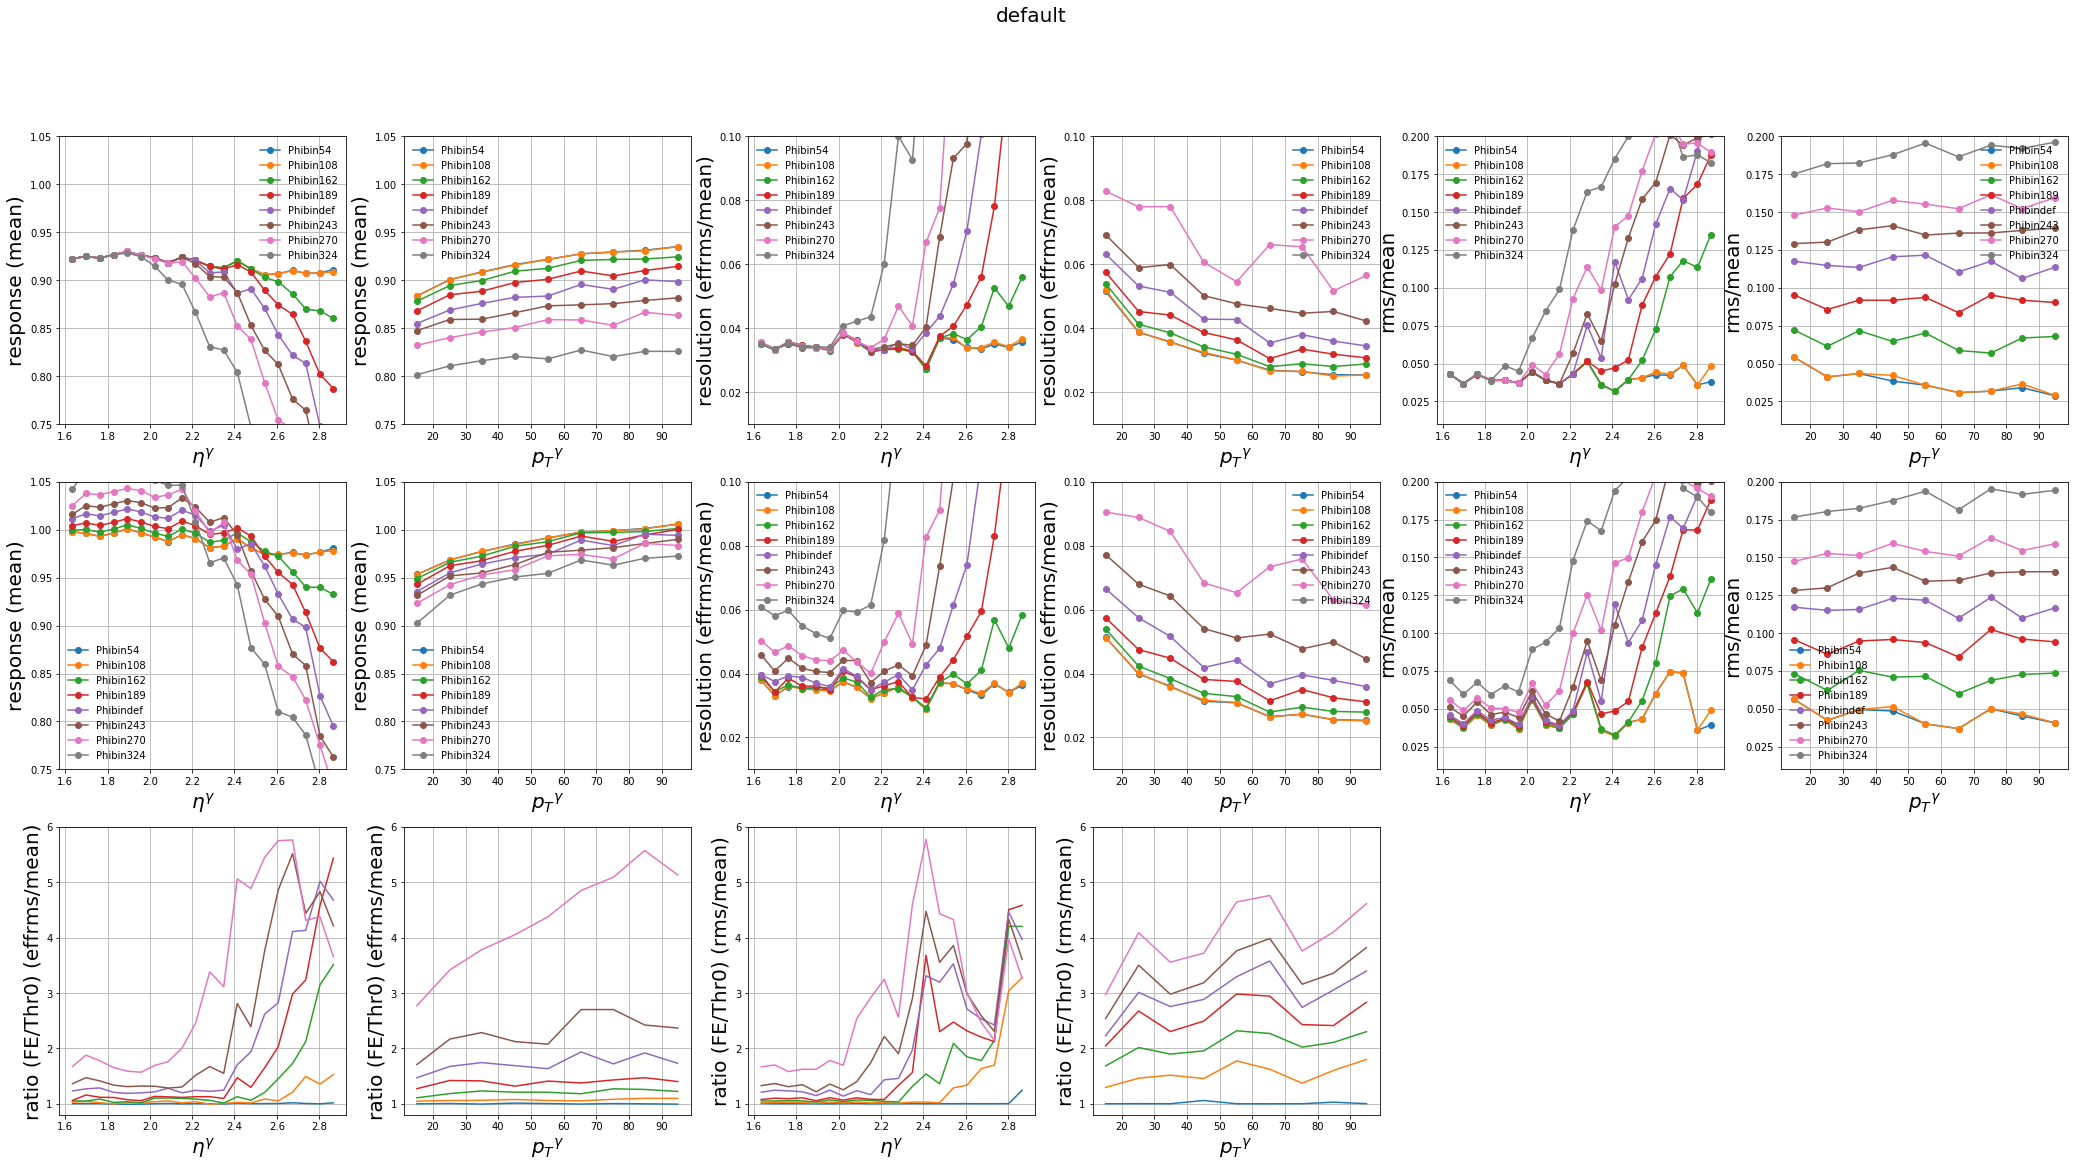

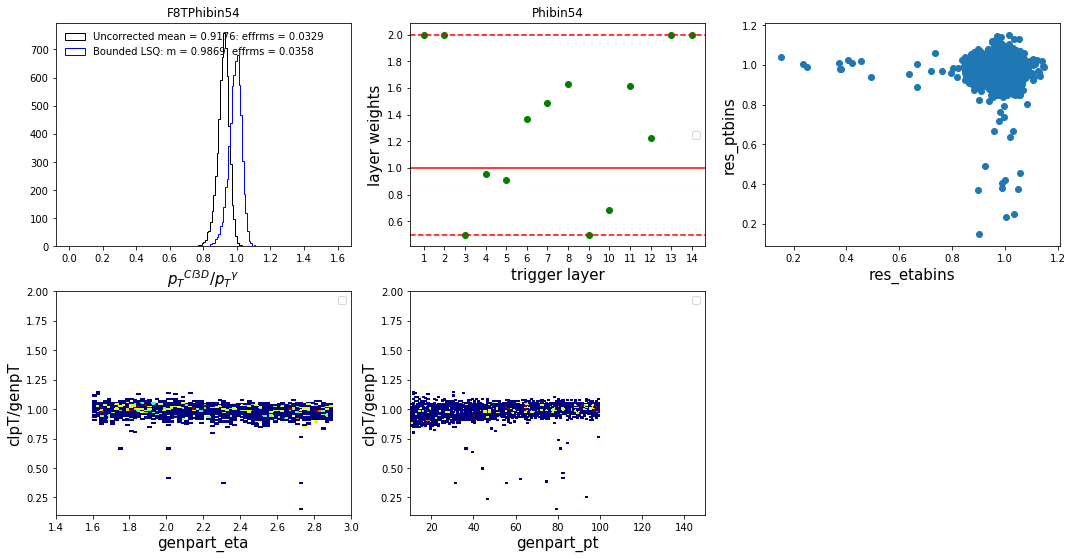

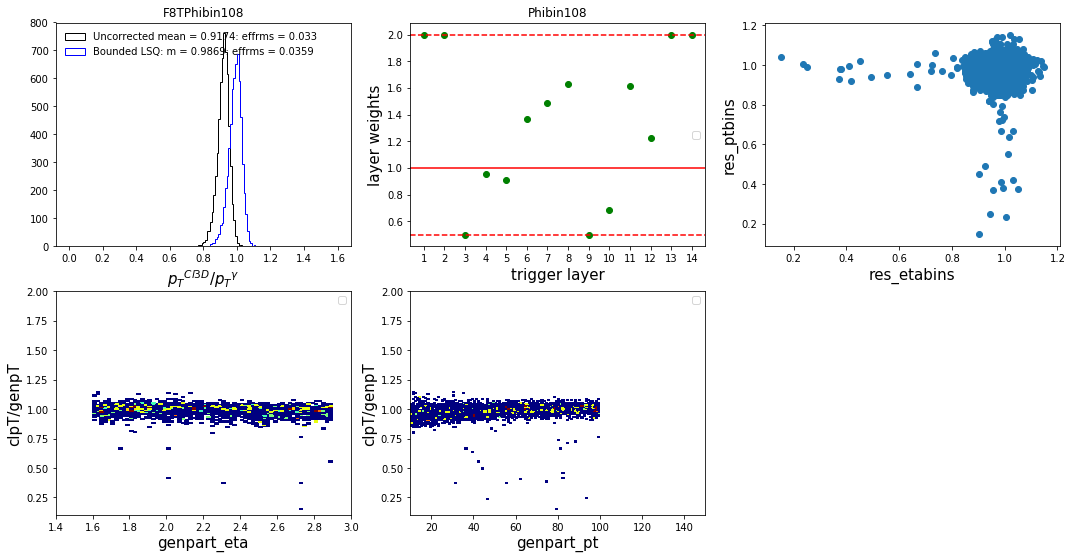

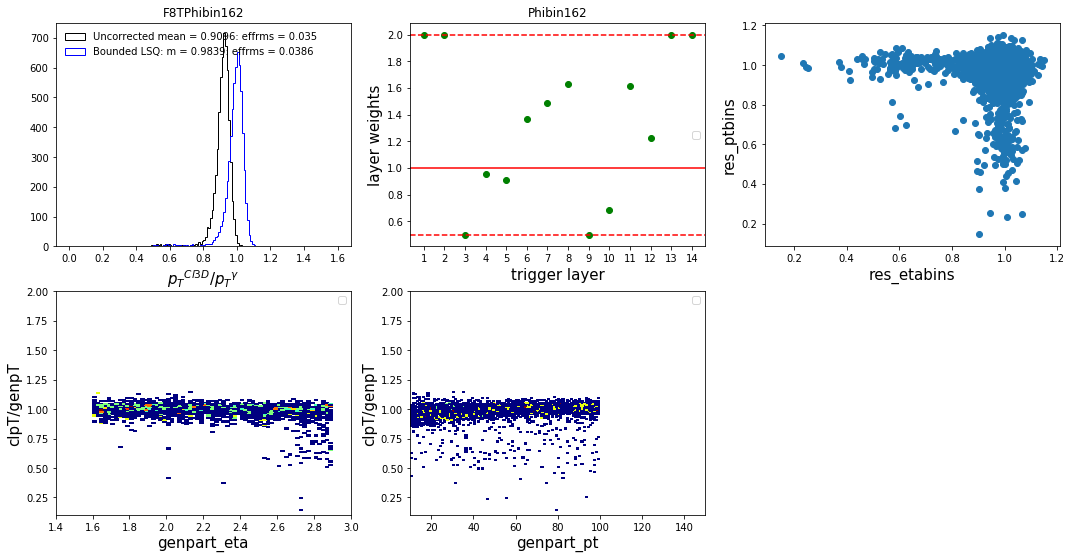

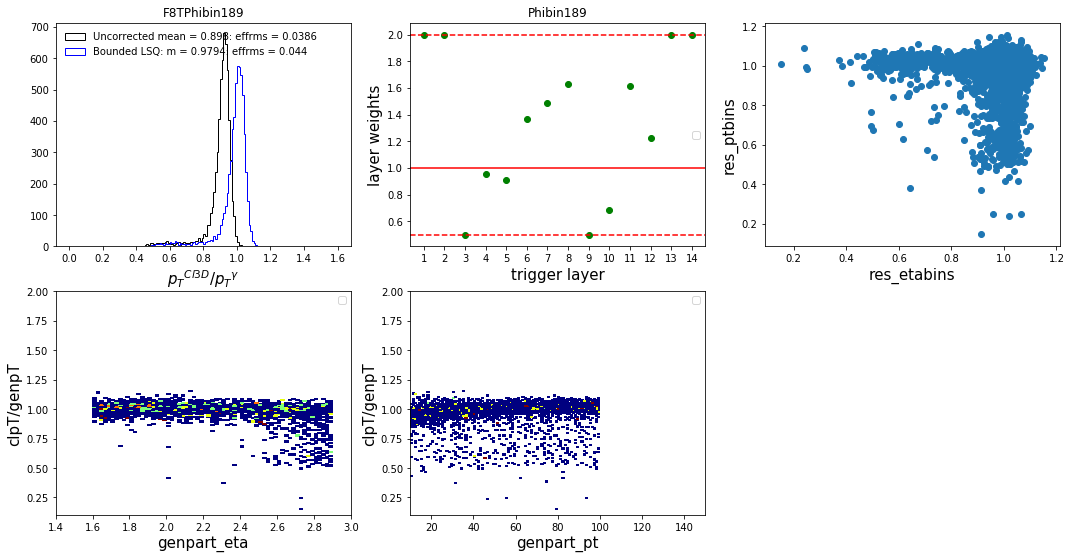

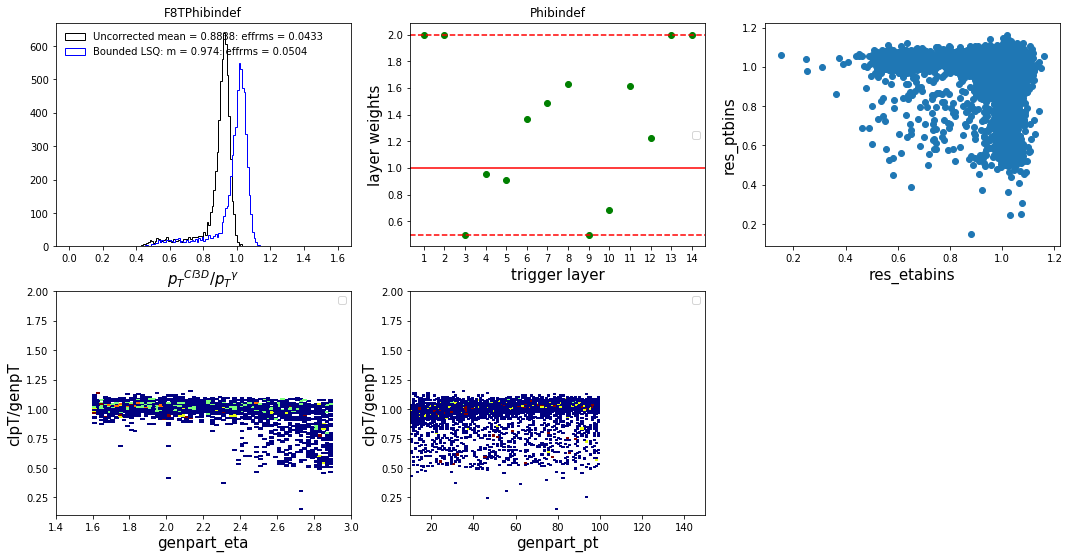

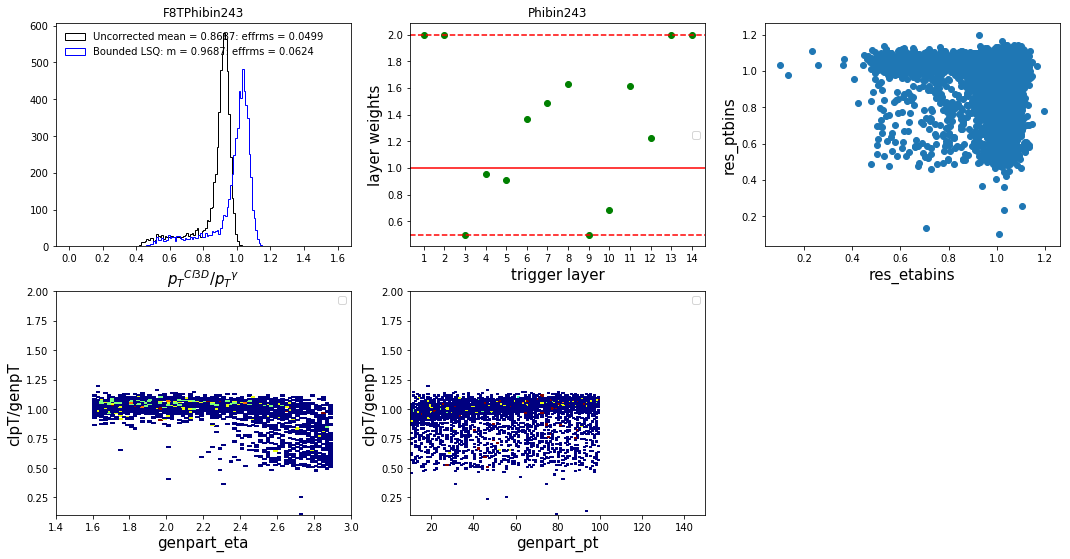

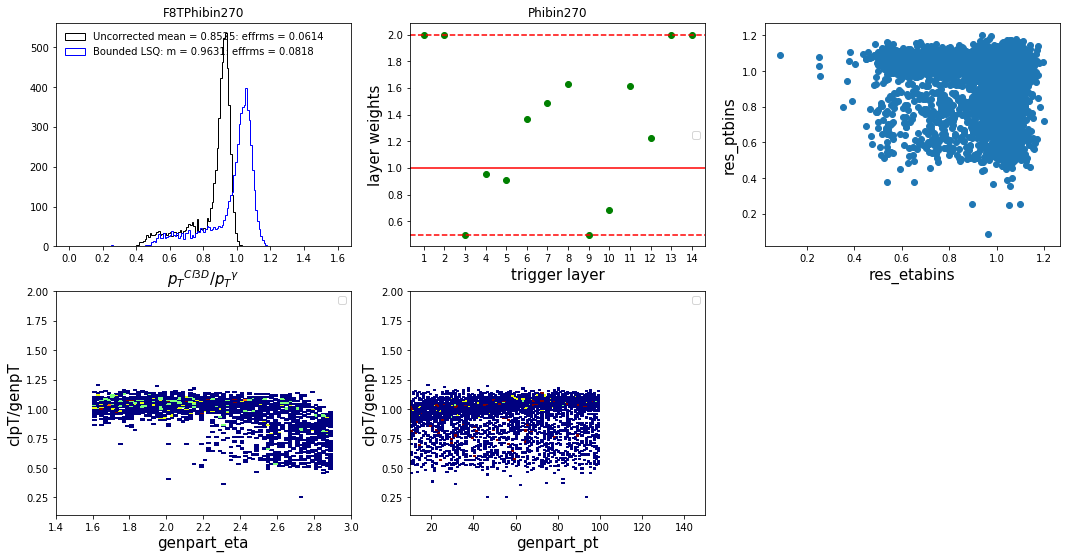

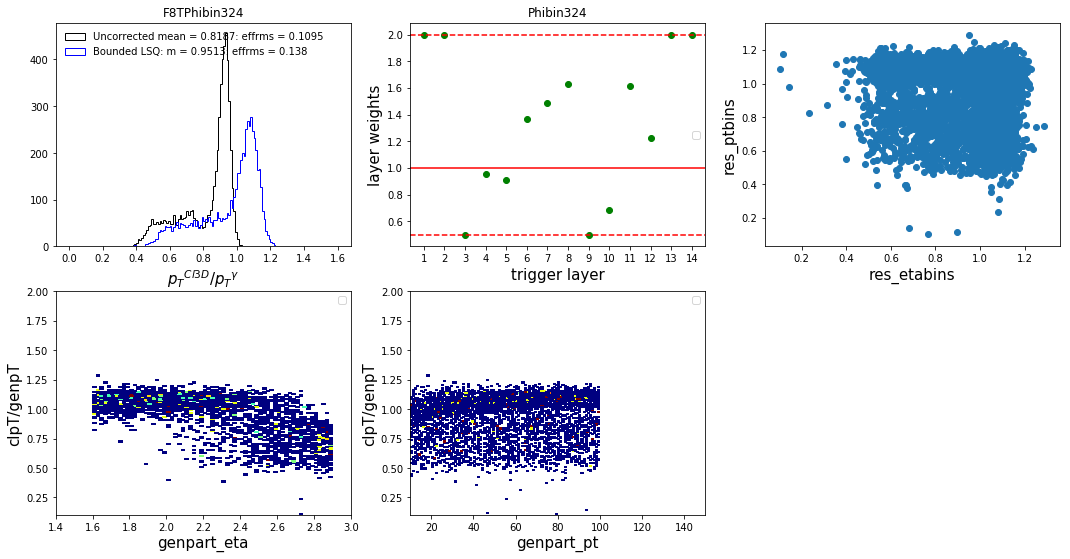

In [12]:
print(os.getcwd())
responseplot = {}
resolutionplot = {}
algoSelevents={}
for i in algoSel:
    print(i)
    print(algos[i])  
    resUnc = algoSel[i]['cl3d_pt']/algoSel[i]['genpart_pt']
    meanUnc = np.mean(resUnc)
    effrmsUnc = rmseff(resUnc)
    algoSel[i]['resCor_lsq'] = algoSel[i]['ClPt_blsq']/algoSel[i]['genpart_pt']  
    meanCor_lsq = np.mean(algoSel[i]['resCor_lsq'])
    selevents=((algoSel[i]['genpart_pt'] > 10.0))#& (algoSel[i]['genpart_pt'] < 100.0))
               # (np.abs(algoSel[i]['genpart_eta']) > 1.6) & (np.abs(algoSel[i]['genpart_eta']) < 1.73))
    algoSelevents[i] = algoSel[i][selevents]
    algoSelevents[i]['resCorSel_lsq'] = algoSelevents[i]['ClPt_blsq']/algoSelevents[i]['genpart_pt']

    responseplot[i] = np.mean(algoSelevents[i]['resCor_lsq'])
    resolutionplot[i] = rmseff(algoSelevents[i]['resCor_lsq'])/np.mean(algoSelevents[i]['resCor_lsq'])
        
    algoSelevents[i]['bineta'] = ((np.abs(algoSelevents[i]['genpart_eta']) - 1.6)/0.065).astype('int32')
    algoSelevents[i]['binpt'] = ((algoSelevents[i]['genpart_pt']- 10.0)/10.0).astype('int32')
    algoSelevents[i]['resUnCor'] = algoSelevents[i]['cl3d_pt']/algoSelevents[i]['genpart_pt']
    algoSelevents[i]['abseta'] = np.abs(algoSelevents[i]['genpart_eta'])
    df_mean_eta = algoSelevents[i].groupby(['bineta']).mean()
    df_mean_pt = algoSelevents[i].groupby(['binpt']).mean()
    df_effrms_eta = algoSelevents[i].groupby(['bineta']).apply(lambda x: rmseff(x.resUnCor))
    df_effrms_pt = algoSelevents[i].groupby(['binpt']).apply(lambda x: rmseff(x.resUnCor))
    df_effrms_etaC = algoSelevents[i].groupby(['bineta']).apply(lambda x: rmseff(x.resCorSel_lsq))
    df_effrms_ptC = algoSelevents[i].groupby(['binpt']).apply(lambda x: rmseff(x.resCorSel_lsq)) 
    df_rms_eta = algoSelevents[i].groupby(['bineta']).apply(lambda x: np.std(x.resUnCor))
    df_rms_pt = algoSelevents[i].groupby(['binpt']).apply(lambda x: np.std(x.resUnCor))
    df_rms_etaC = algoSelevents[i].groupby(['bineta']).apply(lambda x: np.std(x.resCorSel_lsq))
    df_rms_ptC = algoSelevents[i].groupby(['binpt']).apply(lambda x: np.std(x.resCorSel_lsq))
    
    print(df_mean_eta.abseta)
    print(df_mean_pt.genpart_pt)
    if(i==0):
        df_effrms_eta_refO = df_effrms_eta
        df_effrms_pt_refO = df_effrms_pt
        df_effrms_etaC_refO = df_effrms_etaC
        df_effrms_ptC_refO = df_effrms_ptC 
        df_rms_eta_refO = df_rms_eta
        df_rms_pt_refO = df_rms_pt
        df_rms_etaC_refO = df_rms_etaC
        df_rms_ptC_refO = df_rms_ptC
    if(i>0):
        df_effrms_eta_rel = df_effrms_eta/df_effrms_eta_refO
        df_effrms_pt_rel = df_effrms_pt/df_effrms_pt_refO
        df_effrms_etaC_rel = df_effrms_etaC/df_effrms_etaC_refO
        df_effrms_ptC_rel = df_effrms_ptC/df_effrms_ptC_refO
        df_rms_eta_rel = df_rms_eta/df_rms_eta_refO
        df_rms_pt_rel = df_rms_pt/df_rms_pt_refO
        df_rms_etaC_rel = df_rms_etaC/df_rms_etaC_refO
        df_rms_ptC_rel = df_rms_ptC/df_rms_ptC_refO
        
    Ntriglayer = len(cllayerpt[j])
    layerN = np.array([(t+1) for t in range(Ntriglayer)])
    if(calibration == 'direct' and PUmethod == 'sub'):
        coefflsq_plot = np.array([(coefflsq[p]) for p in range(len(coefflsq)-1)]) 
    if(i==0):
        fig = plt1.figure(num='performance1',figsize=(36,18))
        fig.suptitle(algoVar[0],fontsize=20)
    plt1.figure(num='performance1')
    plt1.subplot(361)
    plt1.errorbar((df_mean_eta.abseta), df_mean_eta.resUnCor, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.75,1.05)
    plt1.xlabel('$\eta^\gamma$',fontsize=20)
    plt1.ylabel('response (mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(362)
    plt1.errorbar((df_mean_pt.genpart_pt), df_mean_pt.resUnCor, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.75,1.05)
    plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
    plt1.ylabel('response (mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(363) 
    plt1.errorbar((df_mean_eta.abseta), df_effrms_eta/df_mean_eta.resUnCor, linestyle='-', marker='o',  label=algoTitle[i])
    plt1.ylim(0.01,0.10)
    plt1.xlabel('$\eta^\gamma$',fontsize=20)
    plt1.ylabel('resolution (effrms/mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(364) 
    plt1.errorbar(np.abs(df_mean_pt.genpart_pt), df_effrms_pt/df_mean_pt.resUnCor, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.01,0.10)
    plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
    plt1.ylabel('resolution (effrms/mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(365) 
    plt1.errorbar((df_mean_eta.abseta), df_rms_eta/df_mean_eta.resUnCor, linestyle='-', marker='o',  label=algoTitle[i])
    plt1.ylim(0.01,0.20)
    plt1.xlabel('$\eta^\gamma$',fontsize=20)
    plt1.ylabel('rms/mean',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(366)  
    plt1.errorbar(np.abs(df_mean_pt.genpart_pt), df_rms_pt/df_mean_pt.resUnCor, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.01,0.2)
    plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
    plt1.ylabel('rms/mean',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(367)
    plt1.errorbar((df_mean_eta.abseta), df_mean_eta.resCorSel_lsq, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.75,1.05)
    plt1.xlabel('$\eta^\gamma$',fontsize=20)
    plt1.ylabel('response (mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(368)
    plt1.errorbar((df_mean_pt.genpart_pt), df_mean_pt.resCorSel_lsq, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.75,1.05)
    plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
    plt1.ylabel('response (mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(369)
    plt1.errorbar((df_mean_eta.abseta),df_effrms_etaC/df_mean_eta.resCorSel_lsq, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.01,0.10)
    plt1.xlabel('$\eta^\gamma$',fontsize=20)
    plt1.ylabel('resolution (effrms/mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(3,6,10)
    plt1.errorbar((df_mean_pt.genpart_pt),df_effrms_ptC/df_mean_pt.resCorSel_lsq, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.01,0.10)
    plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
    plt1.ylabel('resolution (effrms/mean)',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(3,6,11)
    plt1.errorbar((df_mean_eta.abseta),df_rms_etaC/df_mean_eta.resCorSel_lsq, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.01,0.2)
    plt1.xlabel('$\eta^\gamma$',fontsize=20)
    plt1.ylabel('rms/mean',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    plt1.subplot(3,6,12)
    plt1.errorbar((df_mean_pt.genpart_pt),df_rms_ptC/df_mean_pt.resCorSel_lsq, linestyle='-', marker='o', label=algoTitle[i])
    plt1.ylim(0.01,0.2)
    plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
    plt1.ylabel('rms/mean',fontsize=20)
    plt1.legend(frameon=False)
    plt1.grid(True)
    if(i>0):
        plt1.subplot(3,6,13)
        plt1.errorbar((df_mean_eta.abseta),df_effrms_etaC_rel, linestyle='-')
        plt1.ylim(0.8,6.0)
        plt1.xlabel('$\eta^\gamma$',fontsize=20)
        plt1.ylabel('ratio (FE/Thr0) (effrms/mean)',fontsize=20)
        plt1.legend(frameon=False)
        plt1.grid(True)
        plt1.subplot(3,6,14)
        plt1.errorbar(np.abs(df_mean_pt.genpart_pt),df_effrms_ptC_rel, linestyle='-')
        plt1.ylim(0.8,6.0)
        plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
        plt1.ylabel('ratio (FE/Thr0) (effrms/mean)',fontsize=20)
        plt1.legend(frameon=False)    
        plt1.grid(True)
        plt1.subplot(3,6,15)
        plt1.errorbar((df_mean_eta.abseta),df_rms_etaC_rel, linestyle='-')
        plt1.ylim(0.8,6.0)
        plt1.xlabel('$\eta^\gamma$',fontsize=20)
        plt1.ylabel('ratio (FE/Thr0) (rms/mean)',fontsize=20)
        plt1.legend(frameon=False)
        plt1.grid(True)
        plt1.subplot(3,6,16)
        plt1.errorbar(np.abs(df_mean_pt.genpart_pt),df_rms_ptC_rel, linestyle='-')
        plt1.ylim(0.8,6.0)
        plt1.xlabel('$p{_T}^{\gamma}$',fontsize=20)
        plt1.ylabel('ratio (FE/Thr0) (rms/mean)',fontsize=20)
        plt1.legend(frameon=False)    
        plt1.grid(True)
    plt1.savefig('performance.png')   
    plt1.figure(figsize=(18,14)) 
    if(plotresolution=='True'):
        plt1.subplot(331)
        plt1.hist(resUnc,bins=np.linspace(0.0,1.6,161),histtype='step',color='black',label='Uncorrected mean = '+str(np.around(meanUnc, decimals = 4))+': effrms = '+str(np.around(effrmsUnc, decimals = 4)))
        plt1.hist(algoSel[i]['resCor_lsq'],bins=np.linspace(0.0,1.6,161),histtype='step',color='blue',label='Bounded LSQ'+': m = '+str(np.around(meanCor_lsq, decimals = 4))+': effrms = '+str(np.around(rmseff(algoSel[i]['resCor_lsq']), decimals = 4)))
        plt1.xlabel('$p{_T}^{Cl3D}$/$p{_T}^{\gamma}$',fontsize=15)
        plt1.title(algos[i]);
        plt1.legend(loc=2,frameon=False)
        plt1.subplot(332)
        plt1.scatter(layerN,coefflsq, c='green')
        if(calibration == 'direct' and PUmethod == 'sub'):
            plt1.annotate('PU weight = '+str(np.around(coefflsq[14], decimals = 4)), xy=(0.6,0.9),xycoords='axes fraction',fontsize=14)
        #if((i<2) or (i==11) or (i>21 and i<25) or (i>32 and i<39)):
        #    plt1.axhline(y=meanBounds, color='r', linestyle='-') 
        #    plt1.axhline(y=meanBounds/2, color='r', linestyle='--')
        #    plt1.axhline(y=meanBounds*2, color='r', linestyle='--')
        #if((i>1 and i<11) or (i>11 and i<22) or (i>24 and i<33) or (i>38)):
        plt1.axhline(y=1.0, color='r', linestyle='-') ##y=meanBounds
        plt1.axhline(y=0.5, color='r', linestyle='--') ##y=meanBounds/2
        plt1.axhline(y=2.0, color='r', linestyle='--') ##y=meanBounds*2
        plt1.xticks(layerN)
        plt1.legend()
        plt1.xlabel('trigger layer',fontsize=15)
        plt1.ylabel('layer weights',fontsize=15)
        plt1.title(algoTitle[i]);
        plt1.subplot(333)
        def fn(x):
            return x.ClPt_blsq/x.genpart_pt
        df_effrms_etaC_plot = algoSelevents[i].groupby(['bineta']).apply(lambda x: fn(x)) ##res_etabins=x.cl3d_pt/x.genpart_pt
        df_effrms_ptC_plot = algoSelevents[i].groupby(['binpt']).apply(lambda x: fn(x))
        plt.scatter(df_effrms_etaC_plot, df_effrms_ptC_plot)#, s=area, c=colors, alpha=0.5)
        #df_effrms_etaC_plot.plot.scatter(x='res_etabins', y='res_ptbins')
        plt1.xlabel('res_etabins',fontsize=15)
        plt1.ylabel('res_ptbins',fontsize=15)
        plt1.subplot(334)
        df_res_ptC_plot = algoSelevents[i].groupby(['binpt']).apply(lambda x: plt1.hist2d(x.genpart_eta,x.ClPt_blsq/x.genpart_pt,bins=(80,190),range=[[1.4,3.0],[0.1,2.0]],cmap=plt.cm.jet,norm=LogNorm()))
        plt1.xlabel('genpart_eta',fontsize=15)
        plt1.legend()
        plt1.ylabel('clpT/genpT',fontsize=15)
        plt1.subplot(335)
        df_res_etaC_plot = algoSelevents[i].groupby(['bineta']).apply(lambda x: plt1.hist2d(x.genpart_pt,x.ClPt_blsq/x.genpart_pt,bins=(140,190),range=[[10,150],[0.1,2.0]],cmap=plt.cm.jet,norm=LogNorm()))
        plt1.xlabel('genpart_pt',fontsize=15)
        plt1.legend()
        plt1.ylabel('clpT/genpT',fontsize=15)
        plt1.savefig('Resolution'+ algos[i] +'.png')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


{0: 0.986944369498984, 1: 0.9868768679119211, 2: 0.9838560395254763, 3: 0.9793646878358759, 4: 0.9740308127707183, 5: 0.9686663463877756, 6: 0.9630770867757427, 7: 0.951340031231303}
{0: 0.036274200549149795, 1: 0.03634934269355476, 2: 0.03926692138567278, 3: 0.044888984982274, 4: 0.051721904973207465, 5: 0.06444672638686656, 6: 0.08490290019391962, 7: 0.1450605435078172}


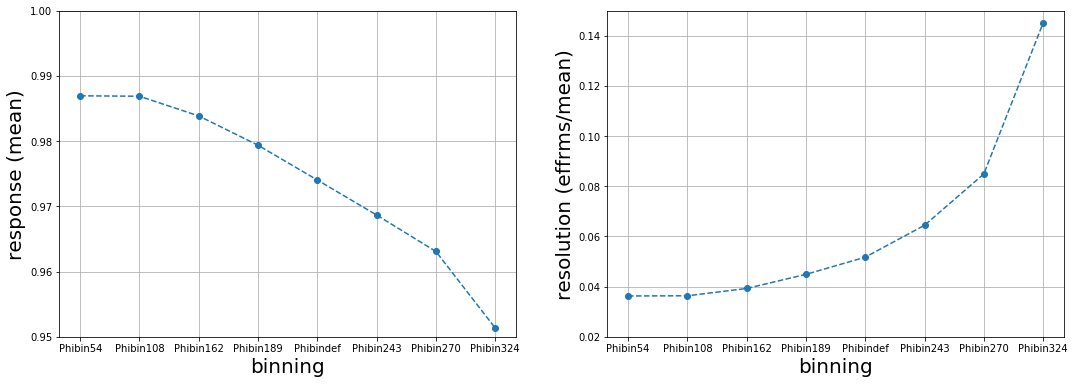

In [13]:
print(responseplot)
print(resolutionplot)
algosphibins=np.array(['Phibin54','Phibin108','Phibin162','Phibin189','Phibindef','Phibin243','Phibin270','Phibin324'])
plt2.figure(num='Thbinperf',figsize=(18,6))
plt2.subplot(121)
plt2.plot(algosphibins,list(responseplot.values()), linestyle='--', marker='o',label='')
plt2.xlabel('binning',fontsize=20)
plt2.ylabel('response (mean)',fontsize=20)
plt2.ylim(0.95,1.0)
plt2.grid(True)
plt2.legend(frameon=False)
plt2.subplot(122)
plt2.plot(algosphibins,list(resolutionplot.values()), linestyle='--', marker='o',label='')
plt2.xlabel('binning',fontsize=20)
plt2.ylabel('resolution (effrms/mean)',fontsize=20)
plt2.legend(frameon=False)
plt2.ylim(0.02,0.15)
plt2.grid(True)
plt2.legend(frameon=False)
plt2.savefig('PerformancevsBinning'+'.png')